# HW4: Paraphrase Identification 

## HW4 Delivery policies
|Rules | Punishment (If you do not follow the rule) | Note |
|-|-|-|
| Name the folder as `FDA_HW4_F12345678` and zip it | -5| |
| Include `requirements.txt` in the folder | -5 | |
| Use HuggingFace `dataset` and `trainer` for HW4 | -5 | |
| Results can be reproduced | -10 | We will run your code! |
| Include the best model checkpoint in your zipped folder | -10 |  |
| Note the approximate running time | -5 |  |
| Note the GPU card(s) you use | -5 |  |
| Do not use ChatGPT to predict the answers directly | -20 | You can use ChatGPT to help coding work. |
| Do not use models not from HuggingFace | -20 |  |
| Do not copy and paste the code from your classmates | -20 | You should finish your own work. |

## HW4 Scoring rules
|Rules | Scores|
|-|-|
| Finish the six `# TODO`s (each for +10)  | +60  |
| Introduce the model or methods you use in Markdown | +20 |
| Accuracy on the Test set >= 0.8 | +20 |
| Accuracy on the Test set >= 0.85 | +10 |

* Note: Accuracy on the Test set **needs to be shown in the input of the final cell.** Please DO NOT MODIFY the final cell. 


## Submitted Folder Structure Example
- After unzipping, your folder should look like this (in this example, student_id is F12345678)
- `best.ckpt` is your best model checkpoint. TAs will run your code using this checkpoint. 
- If you use any other extra files, please include it in the folder. 
```
.
└── FDA_HW4_F12345678/
    ├── FDA2023_HW4_ans.ipynb
    ├── requirements.txt
    └── best.ckpt 
```

In [1]:
# Uncomment in Collab
# %pip install -r requirements.txt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from pathlib import Path
from datetime import datetime
import json
import pandas as pd
import numpy as np
import jieba
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import torch
##### HuggingFace libraries #####
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
##### HuggingFace libraries #####

In [3]:
# Uncomment the following lines to download the dataset
#!wget https://storage.googleapis.com/paws/pawsx/x-final.tar.gz
#!tar zxvf x-final.tar.gz

In [4]:
data_dir = Path("x-final/zh")
data_files = list(data_dir.glob("*.tsv"))
data_dict = {}

for split in ["train", "dev", "test"]:
    print(split)
    for filename in data_files:
        if split in str(filename):
            print(f"{split}: {filename}")
            df = pd.read_csv(filename, sep="\t")
            df_without_nan = df.dropna()
            data_dict[split] = df_without_nan
            break

train
train: x-final\zh\translated_train.tsv
dev
dev: x-final\zh\dev_2k.tsv
test
test: x-final\zh\test_2k.tsv


## Explore the mean length of sentences in the dataset
### # TODO1: Plot and show the following figure
- Hint: Get the length of each sentence with jieba first.

<div>
<img src='https://drive.google.com/uc?export=view&id=1FjkMnxHuW8FFAhzh6Xlpzqf_b-6_33Bj' width="900"/>
</div>

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Tim\AppData\Local\Temp\jieba.cache
Loading model cost 0.318 seconds.
Prefix dict has been built successfully.
C:\Users\Tim\AppData\Local\Temp\ipykernel_19080\3326094718.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_lengths, kde=True, label="train", hist_kws={'edgecolor':'none'}, ax=ax[0])
C:\Users\Tim\AppData\Local\Temp\ipykernel_19080\3326094718.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or

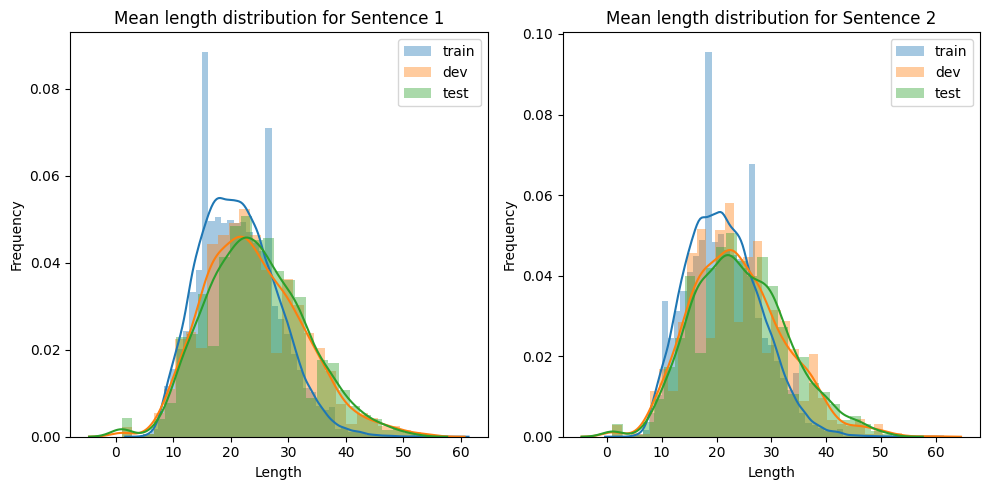

In [5]:
def get_token_length(sentence: str) -> int:
    tokens = jieba.lcut(sentence)
    return len(tokens)

# Code here for the TODO1
# Token Length Visualization
train_lengths = data_dict["train"]["sentence1"].apply(get_token_length)
dev_lengths = data_dict["dev"]["sentence1"].apply(get_token_length)
test_lengths = data_dict["test"]["sentence1"].apply(get_token_length)
train_lengths2 = data_dict["train"]["sentence2"].apply(get_token_length)
dev_lengths2 = data_dict["dev"]["sentence2"].apply(get_token_length)
test_lengths2 = data_dict["test"]["sentence2"].apply(get_token_length)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.distplot(train_lengths, kde=True, label="train", hist_kws={'edgecolor':'none'}, ax=ax[0])
sns.distplot(dev_lengths, kde=True, label="dev", hist_kws={'edgecolor':'none'}, ax=ax[0])
sns.distplot(test_lengths, kde=True, label="test", hist_kws={'edgecolor':'none'}, ax=ax[0])
ax[0].set_xlabel("Length")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Mean length distribution for Sentence 1")
ax[0].legend()

sns.distplot(train_lengths2, kde=True, label="train", hist_kws={'edgecolor':'none'}, ax=ax[1])
sns.distplot(dev_lengths2, kde=True, label="dev", hist_kws={'edgecolor':'none'}, ax=ax[1])
sns.distplot(test_lengths2, kde=True, label="test", hist_kws={'edgecolor':'none'}, ax=ax[1])
ax[1].set_xlabel("Length")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Mean length distribution for Sentence 2")
ax[1].legend()

plt.tight_layout()
plt.show()

In [6]:
# Transform the data into HuggingFace Dataset format

trainset = Dataset.from_pandas(data_dict["train"])
devset = Dataset.from_pandas(data_dict["dev"])
testset = Dataset.from_pandas(data_dict["test"])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
configs = {
    "seed": 42,
    "lr": 2e-5,
    "train_batch_size": 64,
    "test_batch_size": 256,
    "num_epochs": 2,
    "gradient_accumulation_steps": 1,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "output_dir": "outputs",
    "model_name": "GanymedeNil/text2vec-large-chinese" # TODO2: choose a model from https://huggingface.co/models ,
}
current_time = datetime.now().strftime("%m%d-%H%M%S")
brief_model_name = configs["model_name"].split("/")[-1]
EXP_NAME = f"{current_time}_{brief_model_name}_lr{configs['lr']}"

print("EXP_NAME:", EXP_NAME)

# Save the configs
config_dir = Path(f"{configs['output_dir']}/runs/{EXP_NAME}")
config_dir.mkdir(parents=True)
with open(f"{config_dir}/configs.json", 'w') as f:
    dict_of_params = {k: v for k, v in configs.items()}
    json.dump(dict_of_params, f, indent=4)

EXP_NAME: 0610-184025_text2vec-large-chinese_lr2e-05


In [8]:
tokenizer = AutoTokenizer.from_pretrained(configs["model_name"])

def preprocess_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        padding=True,
    )

In [9]:
# Tokenize the dataset. Use `batched=True` for faster processing.

tokenized_train = trainset.map(preprocess_function, batched=True)# TODO3: Tokenize the trainset
tokenized_devset = devset.map(preprocess_function, batched=True)# TODO3: Tokenize the devset
tokenized_testset = testset.map(preprocess_function, batched=True)# TODO3: Tokenize the testset

Map:   0%|          | 0/49129 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
# Use `DataCollatorWithPadding` to pad the sentences to the maximum length in a batch
# Or you will pad the sentences to the maximum length in the whole dataset

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(
    configs["model_name"], num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GanymedeNil/text2vec-large-chinese and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
training_args = TrainingArguments(
    seed=configs["seed"],
    # TODO4: Set up your training arguments
    learning_rate=configs["lr"],
    per_device_train_batch_size=configs["train_batch_size"],
    per_device_eval_batch_size=configs["test_batch_size"],
    num_train_epochs=configs["num_epochs"],
    gradient_accumulation_steps=configs["gradient_accumulation_steps"],
    weight_decay=configs["weight_decay"],
    warmup_ratio=configs["warmup_ratio"],
    output_dir=configs["output_dir"],
    # Hint: Put your configs here
    # Hint: You can add more arguments via https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments
    # # The remaining arguments in the following lines are adjustable for your use.
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_steps=100,
    logging_dir=f"{configs['output_dir']}/runs/{EXP_NAME}",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    push_to_hub=False,
    report_to="tensorboard",
)

In [13]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)# TODO5: Transform the logits to predictions
    return {"Acc": accuracy_score(y_true=labels, y_pred=predictions)}

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train.shuffle(seed=configs["seed"]),
    eval_dataset=tokenized_devset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [15]:
# Start training
trainer.train()

trainer.save_model(f'model/')
torch.cuda.empty_cache()

c:\Users\Tim\anaconda3\envs\hw4\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1536 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6951, 'learning_rate': 1.2987012987012988e-05, 'epoch': 0.13}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6776392459869385, 'eval_Acc': 0.579, 'eval_runtime': 228.1139, 'eval_samples_per_second': 8.768, 'eval_steps_per_second': 0.035, 'epoch': 0.13}
{'loss': 0.64, 'learning_rate': 1.9334298118668598e-05, 'epoch': 0.26}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.5444933176040649, 'eval_Acc': 0.7365, 'eval_runtime': 500.3175, 'eval_samples_per_second': 3.997, 'eval_steps_per_second': 0.016, 'epoch': 0.26}
{'loss': 0.3974, 'learning_rate': 1.788712011577424e-05, 'epoch': 0.39}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.4272291362285614, 'eval_Acc': 0.803, 'eval_runtime': 317.6023, 'eval_samples_per_second': 6.297, 'eval_steps_per_second': 0.025, 'epoch': 0.39}
{'loss': 0.3523, 'learning_rate': 1.6439942112879886e-05, 'epoch': 0.52}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.45263907313346863, 'eval_Acc': 0.808, 'eval_runtime': 223.329, 'eval_samples_per_second': 8.955, 'eval_steps_per_second': 0.036, 'epoch': 0.52}
{'loss': 0.3029, 'learning_rate': 1.4992764109985529e-05, 'epoch': 0.65}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.4268510639667511, 'eval_Acc': 0.8315, 'eval_runtime': 234.3772, 'eval_samples_per_second': 8.533, 'eval_steps_per_second': 0.034, 'epoch': 0.65}
{'loss': 0.2821, 'learning_rate': 1.3545586107091173e-05, 'epoch': 0.78}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.38321831822395325, 'eval_Acc': 0.8465, 'eval_runtime': 226.0558, 'eval_samples_per_second': 8.847, 'eval_steps_per_second': 0.035, 'epoch': 0.78}
{'loss': 0.2612, 'learning_rate': 1.2098408104196817e-05, 'epoch': 0.91}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.39128634333610535, 'eval_Acc': 0.8415, 'eval_runtime': 228.6027, 'eval_samples_per_second': 8.749, 'eval_steps_per_second': 0.035, 'epoch': 0.91}
{'loss': 0.2263, 'learning_rate': 1.0651230101302461e-05, 'epoch': 1.04}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.41383057832717896, 'eval_Acc': 0.854, 'eval_runtime': 261.7073, 'eval_samples_per_second': 7.642, 'eval_steps_per_second': 0.031, 'epoch': 1.04}
{'loss': 0.1945, 'learning_rate': 9.204052098408106e-06, 'epoch': 1.17}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.4029777944087982, 'eval_Acc': 0.855, 'eval_runtime': 221.5818, 'eval_samples_per_second': 9.026, 'eval_steps_per_second': 0.036, 'epoch': 1.17}
{'loss': 0.1856, 'learning_rate': 7.756874095513748e-06, 'epoch': 1.3}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.3911307752132416, 'eval_Acc': 0.85, 'eval_runtime': 252.8101, 'eval_samples_per_second': 7.911, 'eval_steps_per_second': 0.032, 'epoch': 1.3}
{'loss': 0.18, 'learning_rate': 6.3096960926193926e-06, 'epoch': 1.43}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.39159679412841797, 'eval_Acc': 0.857, 'eval_runtime': 226.4372, 'eval_samples_per_second': 8.832, 'eval_steps_per_second': 0.035, 'epoch': 1.43}
{'loss': 0.1773, 'learning_rate': 4.862518089725037e-06, 'epoch': 1.56}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.39336907863616943, 'eval_Acc': 0.856, 'eval_runtime': 274.0896, 'eval_samples_per_second': 7.297, 'eval_steps_per_second': 0.029, 'epoch': 1.56}
{'loss': 0.1731, 'learning_rate': 3.41534008683068e-06, 'epoch': 1.69}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.3578317165374756, 'eval_Acc': 0.8585, 'eval_runtime': 433.6961, 'eval_samples_per_second': 4.612, 'eval_steps_per_second': 0.018, 'epoch': 1.69}
{'loss': 0.1581, 'learning_rate': 1.9681620839363245e-06, 'epoch': 1.82}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.41763025522232056, 'eval_Acc': 0.864, 'eval_runtime': 235.3987, 'eval_samples_per_second': 8.496, 'eval_steps_per_second': 0.034, 'epoch': 1.82}
{'loss': 0.1672, 'learning_rate': 5.209840810419682e-07, 'epoch': 1.95}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.3907580077648163, 'eval_Acc': 0.86, 'eval_runtime': 184.7492, 'eval_samples_per_second': 10.825, 'eval_steps_per_second': 0.043, 'epoch': 1.95}
{'train_runtime': 23436.631, 'train_samples_per_second': 4.192, 'train_steps_per_second': 0.066, 'train_loss': 0.28946692682802677, 'epoch': 2.0}


## Introduce the model or methods you use here
- GanymedeNil/text2vec-large-chinese
- Based on the derivative model of https://huggingface.co/shibing624/text2vec-base-chinese (shibing624/text2vec-base-chinese), replace MacBERT with LERT, and keep other training conditions unchanged。  
  
shibing624/text2vec-base-chinese
- This is a CoSENT(Cosine Sentence) model: shibing624/text2vec-base-chinese.
It maps sentences to a 768 dimensional dense vector space and can be used for tasks like sentence embeddings, text matching or semantic search.
## approximate running time:390min
## test accuracy:0.858  

## 環境

|環境|名稱|版本|
|-|-|-|
|作業系統|Windows|11|
|程式執行環境|jupyter notebook|6.4.12|
|python 版本|python3|3.9.16|
|安裝環境的方式|conda|22.9.0|

|測試環境|名稱|
|-|-|
|主機板|Z690 AORUS ELITE|
|處理器|Intel Core i5-13600K|
|記憶體|crucial ballistix ddr4-3200 64G(16*4)|
|硬碟|Acer GM7000 2 TB|
|顯示卡|RTX 3090 ROG Strix OC 24G|
|作業系統|Windows 11 家用版 22H2|

In [16]:
# TODO6: Write code to load your best model
# Hint: You can use PyTorch to help load your model.
# Please include your best checkpoint in your HW4 upload file (zipped).
best_model_checkpoint = trainer.state.best_model_checkpoint
loaded_model = AutoModelForSequenceClassification.from_pretrained(best_model_checkpoint)


In [17]:
# Scoring cell (1)

def preprocess_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        padding=True,
        # truncation=True,
    )

test_df = pd.read_csv("x-final/zh/test_2k.tsv", sep="\t")
testset = Dataset.from_pandas(test_df)
tokenized_testset = testset.map(preprocess_function, batched=True)

outputs = trainer.predict(tokenized_testset)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

  0%|          | 0/8 [00:00<?, ?it/s]

## trainer.predict
Returns: NamedTuple A namedtuple with the following keys:

- predictions (np.ndarray): The predictions on test_dataset.
- label_ids (np.ndarray, optional): The labels (if the dataset contained some).
- metrics (Dict[str, float], optional): The potential dictionary of metrics (if the dataset contained labels).

In [18]:
# Scoring cell (2)

print("Test acc: ", outputs.metrics["test_Acc"])

Test acc:  0.858
